#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [3]:
import sys

sys.path.append(
    "../../ex02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [4]:
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [5]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [17]:
def least_squares(y,tx): # Required function 3
    '''Computes the weights to minimize the mean square error, by way of the normal equations
    Args:
        tx: (N,d) array with the samples and their features
        y: (N,) array with the labels
    Returns:
        w: (d,) array with the optimal least squares parameters
        loss: Float denoting the least squares loss of the solution w
    '''
    w = np.linalg.solve(tx.T@tx,tx.T@y)
    e = y - tx @ w
    mse = e.T @ e / len(e)
    return w, mse

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [18]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    ## Grid search ##
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    gridLoss, bestGrid_w0, bestGrid_w1 = get_best_parameters(grid_w0,grid_w1,grid_search(y,tx, grid_w0, grid_w1))

    ## Least squares ##
    lSq_w, lSqLoss = least_squares(y, tx)

    print(f'lSq/grid w: {lSq_w}/{np.array([bestGrid_w0,bestGrid_w1])} \nlSq/grid error: {lSqLoss}/{gridLoss}')


test_your_least_squares()


lSq/grid w: [73.293922   13.47971243]/[72.72727273 13.63636364] 
lSq/grid error: 30.771775737658807/31.117406737219063


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [19]:
# load dataset
x, y = load_data()
print(f"shape of x {x.shape} \nshape of y {y.shape}")


shape of x (50,) 
shape of y (50,)


In [20]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        extendedFeatureMatrix: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """

    extendedFeatureMatrix = np.zeros((len(x),degree+1))
    for d in range(degree+1):
        extendedFeatureMatrix[:,d] = x**d
    
    return extendedFeatureMatrix


In [21]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [22]:
from plots import *




def polynomial_regression_test():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x,degree)
        weights, loss = least_squares(y,tx)
        rmse = (2*loss)**(1/2)

        print(f"Processing {ind+1}th experiment, degree={degree}, rmse={rmse}")
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.6673335515781589
Processing 2th experiment, degree=3, rmse=0.3656912697732368
Processing 3th experiment, degree=7, rmse=0.3530707246084376
Processing 4th experiment, degree=12, rmse=0.34421658852843184


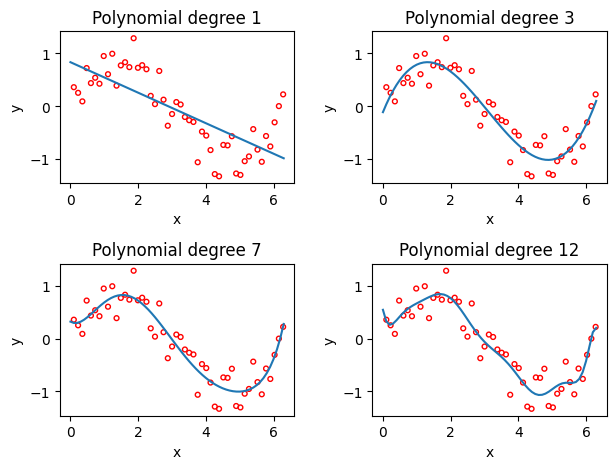

In [23]:
polynomial_regression_test()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [24]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """

    trainLength = int(np.floor(len(y) * ratio))  # The number of samples to be used in the training set

    rng = np.random.default_rng()               # Loading random engine
    shuffledIndices = rng.permutation(len(y))   # Generating indies from 0 to len(y) and shuffling them
    
    return x[shuffledIndices[:trainLength]], x[shuffledIndices[trainLength:]], y[shuffledIndices[:trainLength]], y[shuffledIndices[trainLength:]]

#split_data(x,y,0.8)
    

In [25]:
test(split_data)

❌ The are some issues with your implementation of `split_data`:
**********************************************************************
File "__main__", line 21, in split_data
Failed example:
    split_data(np.arange(13), np.arange(13), 0.8, 1)
Expected:
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
Got:
    (array([ 7,  2, 12,  1,  0,  5,  3, 10, 11,  6]), array([8, 4, 9]), array([ 7,  2, 12,  1,  0,  5,  3, 10, 11,  6]), array([8, 4, 9]))
**********************************************************************


Then, test your `split_data` function below.

In [26]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    x_tr, x_te, y_tr, y_te = split_data(x,y,ratio)

    trainPoly = build_poly(x_tr,degree)
    testPoly = build_poly(x_te,degree)

    w, loss = least_squares(y_tr,trainPoly)

    rmse_tr = np.sqrt(2*loss)
    rmse_te = np.sqrt(2*compute_loss(y_te, testPoly, w))

    print(f"proportion={ratio}, degree={degree}, Training RMSE={rmse_tr:.3f}, Testing RMSE={rmse_te:.3f}")

    return x_tr, x_te, y_tr, y_te, w

Demo time

proportion=0.9, degree=1, Training RMSE=0.663, Testing RMSE=0.724
proportion=0.9, degree=3, Training RMSE=0.362, Testing RMSE=0.417
proportion=0.9, degree=7, Training RMSE=0.353, Testing RMSE=0.388
proportion=0.9, degree=12, Training RMSE=0.342, Testing RMSE=0.384
proportion=0.7, degree=1, Training RMSE=0.631, Testing RMSE=0.760
proportion=0.7, degree=3, Training RMSE=0.321, Testing RMSE=0.460
proportion=0.7, degree=7, Training RMSE=0.344, Testing RMSE=0.427
proportion=0.7, degree=12, Training RMSE=0.324, Testing RMSE=0.648
proportion=0.5, degree=1, Training RMSE=0.639, Testing RMSE=0.697
proportion=0.5, degree=3, Training RMSE=0.314, Testing RMSE=0.464
proportion=0.5, degree=7, Training RMSE=0.324, Testing RMSE=0.621
proportion=0.5, degree=12, Training RMSE=0.320, Testing RMSE=2.924
proportion=0.1, degree=1, Training RMSE=0.344, Testing RMSE=0.730
proportion=0.1, degree=3, Training RMSE=0.362, Testing RMSE=1.011
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=31.975
propor

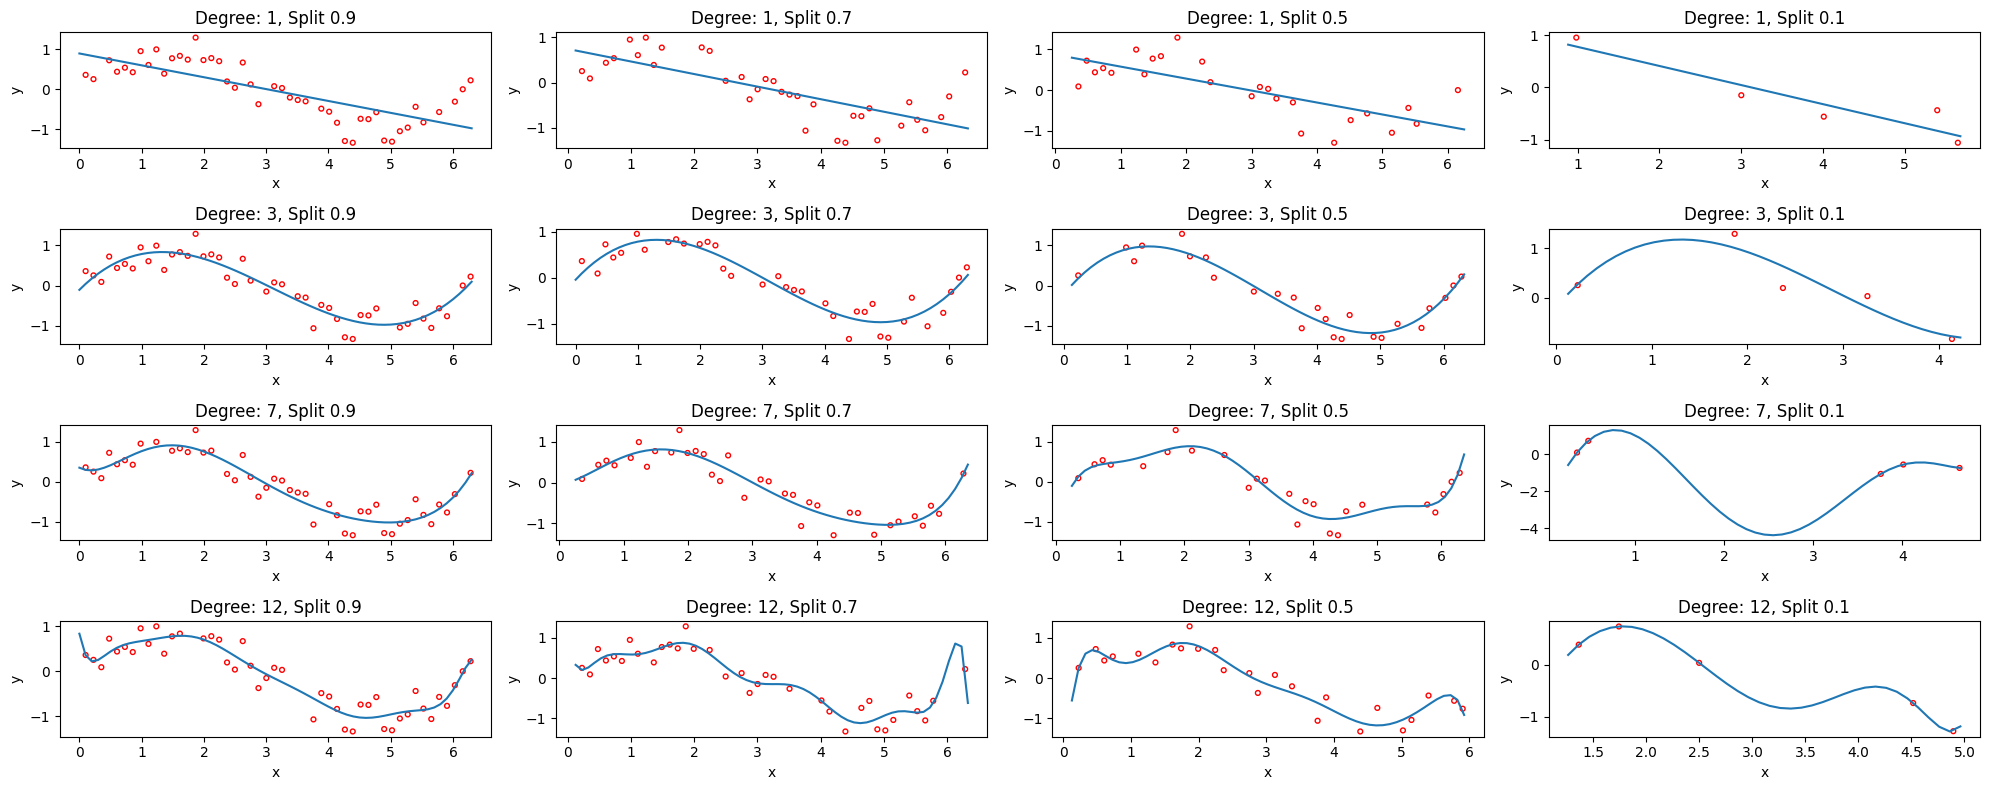

In [27]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [45]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
 
    theInverse = np.linalg.inv(len(y) * lambda_ * np.identity(tx.shape[1]) + tx.T@tx) 
    return theInverse @ tx.T @ y

In [46]:
def test_your_ridge():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search vs. ridge regression with lambda = 0
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    ## Grid search ##
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    gridLoss, bestGrid_w0, bestGrid_w1 = get_best_parameters(grid_w0,grid_w1,grid_search(y,tx, grid_w0, grid_w1))

    ## Least squares ##
    lSq_w, lSqLoss = least_squares(y, tx)

    ## Ridge regression ##
    ridge_w = ridge_regression(y,tx,0)
    ridgeLoss = compute_loss(y,tx,ridge_w)

    print(f'ridge/lSq/grid w: {ridge_w}/{lSq_w}/{np.array([bestGrid_w0,bestGrid_w1])} \nlSq/grid error: {ridgeLoss}/{lSqLoss}/{gridLoss}')


test_your_ridge()


ridge/lSq/grid w: [73.293922   13.47971243]/[73.293922   13.47971243]/[72.72727273 13.63636364] 
lSq/grid error: 30.77177573765875/30.77177573765875/31.117406737219063


In [59]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    x_tr, x_te, y_tr, y_te = split_data(y,x,ratio,seed)

    tx    = build_poly(x_tr,degree)
    tx_te = build_poly(x_te,degree)

    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    for ind, lambda_ in enumerate(lambdas):
        w = ridge_regression(y_tr,tx,lambda_)
        rmse_tr[ind] = 2 * np.sqrt(compute_loss(y_tr,tx,w))
        rmse_te[ind] = 2 * np.sqrt(compute_loss(y_te,tx_te,w))

        print(f"proportion={ratio}, degree={degree}, lambda={lambda_:.3f}, Training RMSE={rmse_tr[ind]:.3f}, Testing RMSE={rmse_te[ind]:.3f}")
        
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=2.169, Testing RMSE=2.330
proportion=0.5, degree=7, lambda=0.000, Training RMSE=2.169, Testing RMSE=2.326
proportion=0.5, degree=7, lambda=0.000, Training RMSE=2.171, Testing RMSE=2.320
proportion=0.5, degree=7, lambda=0.000, Training RMSE=2.176, Testing RMSE=2.314
proportion=0.5, degree=7, lambda=0.000, Training RMSE=2.185, Testing RMSE=2.312
proportion=0.5, degree=7, lambda=0.001, Training RMSE=2.196, Testing RMSE=2.309
proportion=0.5, degree=7, lambda=0.001, Training RMSE=2.208, Testing RMSE=2.292
proportion=0.5, degree=7, lambda=0.003, Training RMSE=2.224, Testing RMSE=2.251
proportion=0.5, degree=7, lambda=0.007, Training RMSE=2.260, Testing RMSE=2.183
proportion=0.5, degree=7, lambda=0.016, Training RMSE=2.334, Testing RMSE=2.113
proportion=0.5, degree=7, lambda=0.037, Training RMSE=2.448, Testing RMSE=2.083
proportion=0.5, degree=7, lambda=0.085, Training RMSE=2.618, Testing RMSE=2.151
proportion=0.5, degree=7, lambda=0.193, 

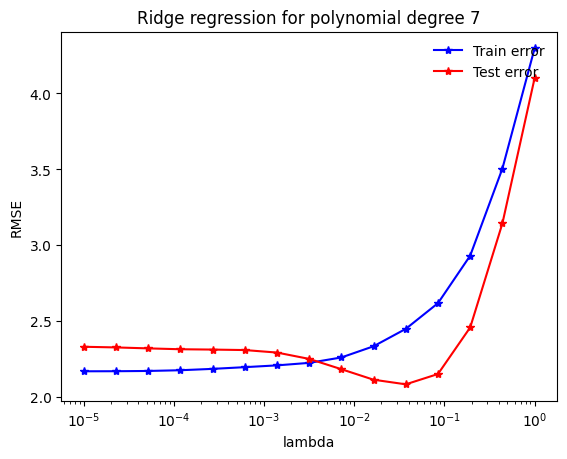

In [60]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)